In [ ]:
# 1) Mount Drive & unzip dataset (same as your previous cells)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os
zip_path = '/content/drive/MyDrive/archive.zip'   # change if needed
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")
else:
    print("Dataset folder already exists.")

dataset_dir = '/content/dataset/eye reaction last'  # same as yours
print("Classes in dataset directory:")
print(os.listdir(dataset_dir))

print("\nClass distribution:")
for cls in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_path):
        print(f"Class '{cls}': {len(os.listdir(class_path))} images")


Dataset extracted.
Classes in dataset directory:
['train', 'test']

Class distribution:
Class 'train': 6 images
Class 'test': 6 images


In [ ]:
train_dir = '/content/dataset/eye reaction last/train'
test_dir  = '/content/dataset/eye reaction last/test'
print("\nTrain folder contents:", os.listdir(train_dir))
print("Test folder contents:", os.listdir(test_dir))


Train folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']
Test folder contents: ['anger', 'fear', 'surprise', 'sad', 'happy', 'disgust']


In [ ]:
# 2) Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import cv2

In [ ]:
# 3) Data generators & augmentation (DenseNet121 uses 224x224)
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 270 images belonging to 6 classes.
Found 138 images belonging to 6 classes.


In [ ]:

# 4) Build DenseNet121-based model (transfer learning)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze all base layers initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,565,382 (28.86 MB)

 Trainable params: 527,878 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# 5) Callbacks & initial training (up to 30 epochs)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_densenet121_emotion_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1913 - loss: 2.2834
Epoch 1: val_loss improved from inf to 1.85395, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.1911 - loss: 2.2761 - val_accuracy: 0.1522 - val_loss: 1.8540
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.2061 - loss: 2.0937
Epoch 2: val_loss improved from 1.85395 to 1.77632, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - accuracy: 0.2077 - loss: 2.0899 - val_accuracy: 0.2464 - val_loss: 1.7763
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.2152 - loss: 2.0084
Epoch 3: val_loss improved from 1.77632 to 1.72302, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 701ms/step - accuracy: 0.2170 - loss: 2.0066 - val_accuracy: 0.2681 - val_loss: 1.7230
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.1908 - loss: 1.9689
Epoch 4: val_loss improved from 1.72302 to 1.69683, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - accuracy: 0.1981 - loss: 1.9586 - val_accuracy: 0.2826 - val_loss: 1.6968
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.2800 - loss: 1.8262
Epoch 5: val_loss improved from 1.69683 to 1.64639, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.2805 - loss: 1.8270 - val_accuracy: 0.3261 - val_loss: 1.6464
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.3090 - loss: 1.7969
Epoch 6: val_loss improved from 1.64639 to 1.58436, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 731ms/step - accuracy: 0.3089 - loss: 1.7925 - val_accuracy: 0.3913 - val_loss: 1.5844
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.3609 - loss: 1.6220
Epoch 7: val_loss improved from 1.58436 to 1.54372, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step - accuracy: 0.3585 - loss: 1.6272 - val_accuracy: 0.4275 - val_loss: 1.5437
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.3945 - loss: 1.5575
Epoch 8: val_loss improved from 1.54372 to 1.51169, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 816ms/step - accuracy: 0.3932 - loss: 1.5612 - val_accuracy: 0.4565 - val_loss: 1.5117
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3746 - loss: 1.5262
Epoch 9: val_loss improved from 1.51169 to 1.48635, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.3746 - loss: 1.5301 - val_accuracy: 0.4783 - val_loss: 1.4864
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.3831 - loss: 1.5074
Epoch 10: val_loss improved from 1.48635 to 1.46106, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 767ms/step - accuracy: 0.3822 - loss: 1.5109 - val_accuracy: 0.5435 - val_loss: 1.4611
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.3482 - loss: 1.6790
Epoch 11: val_loss improved from 1.46106 to 1.43448, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 681ms/step - accuracy: 0.3493 - loss: 1.6736 - val_accuracy: 0.5652 - val_loss: 1.4345
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3747 - loss: 1.5676
Epoch 12: val_loss improved from 1.43448 to 1.42096, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 769ms/step - accuracy: 0.3780 - loss: 1.5612 - val_accuracy: 0.5652 - val_loss: 1.4210
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.4456 - loss: 1.5044
Epoch 13: val_loss improved from 1.42096 to 1.39560, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.4458 - loss: 1.5021 - val_accuracy: 0.5652 - val_loss: 1.3956
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.4288 - loss: 1.5026
Epoch 14: val_loss improved from 1.39560 to 1.36879, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step - accuracy: 0.4282 - loss: 1.4995 - val_accuracy: 0.5652 - val_loss: 1.3688
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4788 - loss: 1.4502
Epoch 15: val_loss did not improve from 1.36879
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 562ms/step - accuracy: 0.4776 - loss: 1.4486 - val_accuracy: 0.5290 - val_loss: 1.3726
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5122 - loss: 1.2964
Epoch 16: val_loss improved from 1.36879 to 1.36342, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 818ms/step - accuracy: 0.5113 - loss: 1.2975 - val_accuracy: 0.5290 - val_loss: 1.3634
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4566 - loss: 1.3854
Epoch 17: val_loss improved from 1.36342 to 1.32890, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.4569 - loss: 1.3849 - val_accuracy: 0.6014 - val_loss: 1.3289
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.4561 - loss: 1.3458
Epoch 18: val_loss did not improve from 1.32890
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 721ms/step - accuracy: 0.4557 - loss: 1.3492 - val_accuracy: 0.5870 - val_loss: 1.3291
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.3980 - loss: 1.4395
Epoch 19: val_loss improved from 1.32890 to 1.31811, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 661ms/step - accuracy: 0.4023 - loss: 1.4338 - val_accuracy: 0.5797 - val_loss: 1.3181
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.5115 - loss: 1.2202
Epoch 20: val_loss improved from 1.31811 to 1.29098, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.5111 - loss: 1.2267 - val_accuracy: 0.6159 - val_loss: 1.2910
Epoch 21/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5284 - loss: 1.2885
Epoch 21: val_loss improved from 1.29098 to 1.29045, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 673ms/step - accuracy: 0.5274 - loss: 1.2859 - val_accuracy: 0.5797 - val_loss: 1.2905
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.5012 - loss: 1.2857
Epoch 22: val_loss improved from 1.29045 to 1.26918, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 821ms/step - accuracy: 0.5029 - loss: 1.2841 - val_accuracy: 0.6159 - val_loss: 1.2692
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5533 - loss: 1.2343
Epoch 23: val_loss improved from 1.26918 to 1.26363, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 658ms/step - accuracy: 0.5510 - loss: 1.2373 - val_accuracy: 0.5797 - val_loss: 1.2636
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.5595 - loss: 1.2355
Epoch 24: val_loss improved from 1.26363 to 1.25166, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 830ms/step - accuracy: 0.5587 - loss: 1.2363 - val_accuracy: 0.5870 - val_loss: 1.2517
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4742 - loss: 1.3014
Epoch 25: val_loss improved from 1.25166 to 1.24909, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - accuracy: 0.4756 - loss: 1.3031 - val_accuracy: 0.6304 - val_loss: 1.2491
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4976 - loss: 1.2576
Epoch 26: val_loss improved from 1.24909 to 1.24656, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 843ms/step - accuracy: 0.4993 - loss: 1.2555 - val_accuracy: 0.6087 - val_loss: 1.2466
Epoch 27/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5351 - loss: 1.2248
Epoch 27: val_loss improved from 1.24656 to 1.23196, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 691ms/step - accuracy: 0.5312 - loss: 1.2275 - val_accuracy: 0.6087 - val_loss: 1.2320
Epoch 28/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5518 - loss: 1.1845
Epoch 28: val_loss improved from 1.23196 to 1.22016, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 837ms/step - accuracy: 0.5522 - loss: 1.1879 - val_accuracy: 0.6159 - val_loss: 1.2202
Epoch 29/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5662 - loss: 1.2242
Epoch 29: val_loss did not improve from 1.22016
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step - accuracy: 0.5644 - loss: 1.2248 - val_accuracy: 0.6232 - val_loss: 1.2230
Epoch 30/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5919 - loss: 1.1626
Epoch 30: val_loss improved from 1.22016 to 1.21934, saving model to best_densenet121_emotion_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 836ms/step - accuracy: 0.5916 - loss: 1.1612 - val_accuracy: 0.6087 - val_loss: 1.2193


In [ ]:
# 6) FINE-TUNING: unfreeze last 20 layers and train for 20 epochs (as you specified)
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train for 20 epochs for fine-tuning
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5263 - loss: 1.2318
Epoch 1: val_loss did not improve from 1.21934
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.5240 - loss: 1.2370 - val_accuracy: 0.5870 - val_loss: 1.2250
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.4459 - loss: 1.3734
Epoch 2: val_loss did not improve from 1.21934
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step - accuracy: 0.4528 - loss: 1.3666 - val_accuracy: 0.5870 - val_loss: 1.2310
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.4877 - loss: 1.2353
Epoch 3: val_loss did not improve from 1.21934
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 722ms/step - accuracy: 0.4893 - loss: 1.2359 - val_accuracy: 0.5725 - val_loss: 1.2358
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.4835 - loss: 1.3383
Epoch 4: val_loss did not improve from 1.21934
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.4848 - loss: 1.3365 - val_accuracy: 0.5797 - val_loss: 1.2396
Epoch 5/20
9/9 ━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step

DenseNet121 - Test Accuracy: 0.5870
Precision: 0.6303
Recall: 0.5870
F1 Score: 0.5916
Cohen's Kappa: 0.5024

Classification Report:

              precision    recall  f1-score   support

       anger       0.65      0.63      0.64        27
     disgust       0.39      0.47      0.42        15
        fear       0.70      0.83      0.76        23
       happy       0.71      0.44      0.55        34
         sad       0.38      0.62      0.47        21
    surprise       0.83      0.56      0.67        18

    accuracy                           0.59       138
   macro avg       0.61      0.59      0.59       138
weighted avg       0.63      0.59      0.59       138



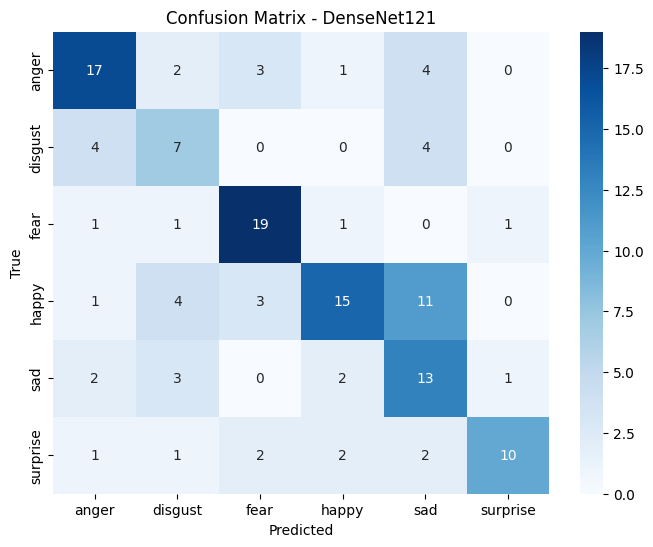

In [ ]:
# 7) Evaluation on test set (classification metrics + confusion matrix)
# Reset generator for prediction
test_generator.reset()
Y_true = test_generator.classes
class_labels_list = list(test_generator.class_indices.keys())

Y_pred_prob = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_prob, axis=1)

accuracy  = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted', zero_division=0)
recall    = recall_score(Y_true, Y_pred, average='weighted', zero_division=0)
f1        = f1_score(Y_true, Y_pred, average='weighted', zero_division=0)
kappa     = cohen_kappa_score(Y_true, Y_pred)

print(f"\nDenseNet121 - Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}\n")

print("Classification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels_list, zero_division=0))

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_list, yticklabels=class_labels_list, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DenseNet121')
plt.show()



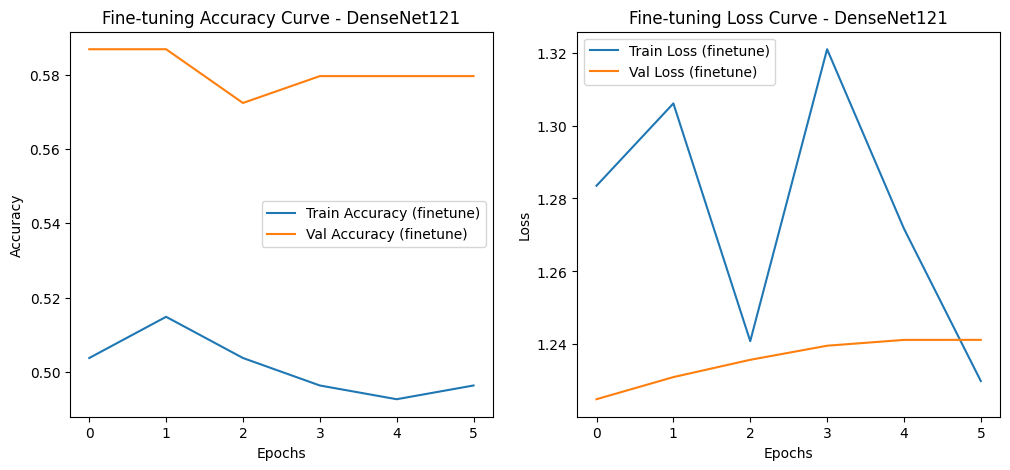

In [ ]:
# 8) PLOT ONLY FINE-TUNING CURVES (accuracy & loss for the fine-tuning phase)
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history.get('accuracy', []), label='Train Accuracy (finetune)')
plt.plot(history_finetune.history.get('val_accuracy', []), label='Val Accuracy (finetune)')
plt.title('Fine-tuning Accuracy Curve - DenseNet121')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history.get('loss', []), label='Train Loss (finetune)')
plt.plot(history_finetune.history.get('val_loss', []), label='Val Loss (finetune)')
plt.title('Fine-tuning Loss Curve - DenseNet121')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

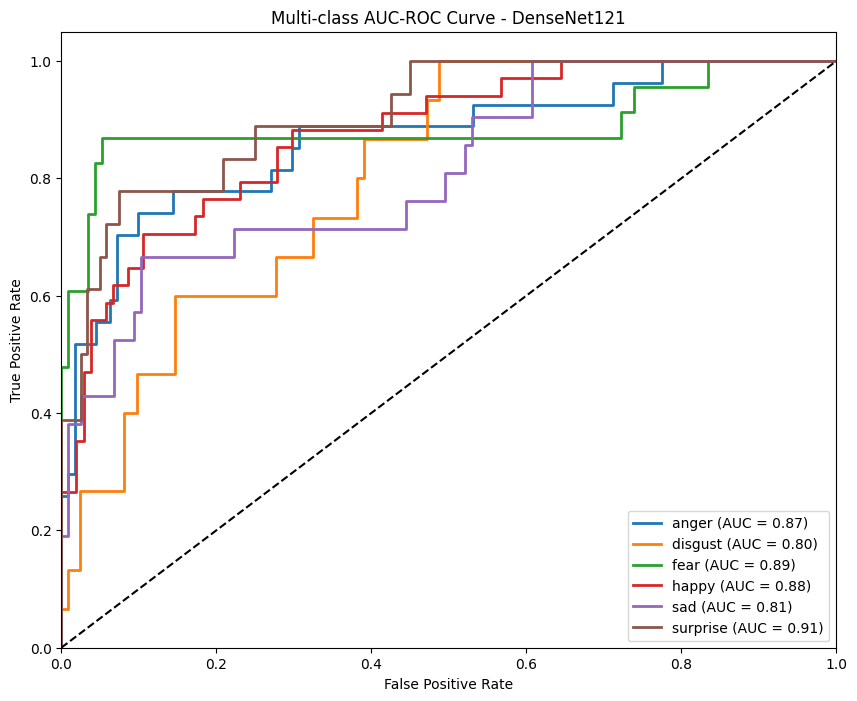

In [ ]:
# 9) ROC / AUC per class (multi-class)
num_classes = len(class_labels_list)
y_true_bin = label_binarize(Y_true, classes=list(range(num_classes)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception as e:
        fpr[i], tpr[i], roc_auc[i] = (None, None, None)
        print(f"ROC error for class {i}: {e}")

plt.figure(figsize=(10,8))
for i in range(num_classes):
    if roc_auc[i] is not None:
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_labels_list[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class AUC-ROC Curve - DenseNet121')
plt.legend(loc='lower right')
plt.show()

Saving test anger.jpg to test anger.jpg
Saving test disgust.jpg to test disgust.jpg
Saving test fear.jpg to test fear.jpg
Saving test happy.jpg to test happy.jpg
Saving test sad.jpg to test sad.jpg
Saving test surprise.jpg to test surprise.jpg
Uploaded files: ['test anger.jpg', 'test disgust.jpg', 'test fear.jpg', 'test happy.jpg', 'test sad.jpg', 'test surprise.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

Image: test anger.jpg
Detected emotion: anger
Confidence: 0.5252


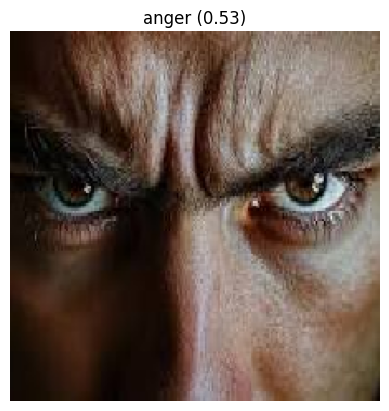

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Image: test disgust.jpg
Detected emotion: disgust
Confidence: 0.2464


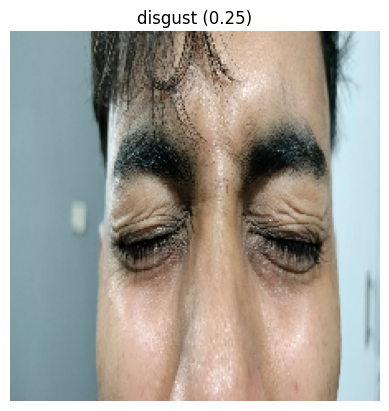

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Image: test fear.jpg
Detected emotion: fear
Confidence: 0.4836


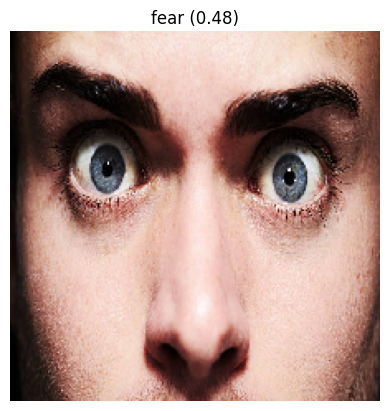

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Image: test happy.jpg
Detected emotion: sad
Confidence: 0.2754


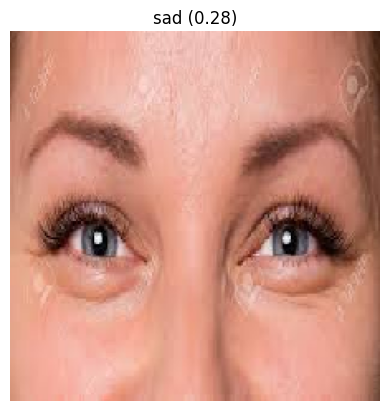

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Image: test sad.jpg
Detected emotion: sad
Confidence: 0.4140


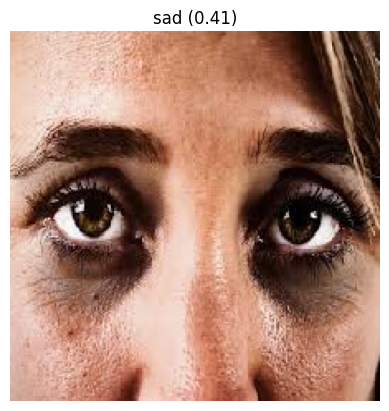

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Image: test surprise.jpg
Detected emotion: surprise
Confidence: 0.3008


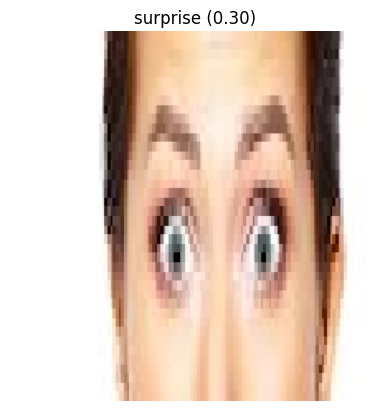

In [ ]:
# 10) Predict on uploaded images (inference)
from google.colab import files
uploaded = files.upload()   # upload images via the browser
uploaded_paths = list(uploaded.keys())
print("Uploaded files:", uploaded_paths)

for img_path in uploaded_paths:
    img = load_img(img_path, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.axis('off')
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_pre = densenet_preprocess(img_arr)

    preds = model.predict(img_pre)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]

    print(f"\nImage: {img_path}")
    print(f"Detected emotion: {class_labels_list[class_idx]}")
    print(f"Confidence: {confidence:.4f}")
    plt.title(f"{class_labels_list[class_idx]} ({confidence:.2f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


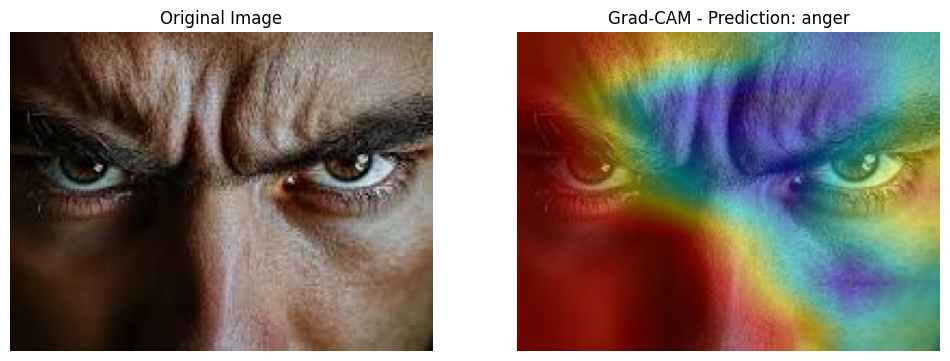

test anger.jpg → Predicted: anger (0.53)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


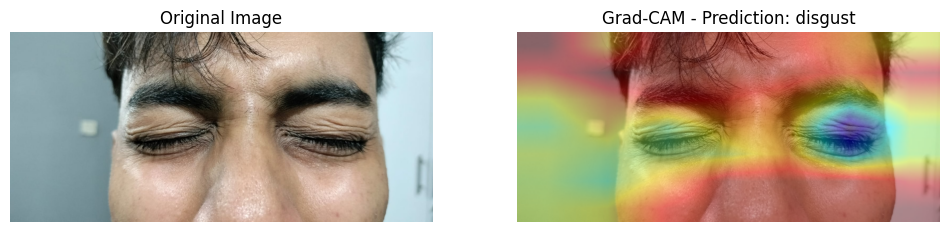

test disgust.jpg → Predicted: disgust (0.25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


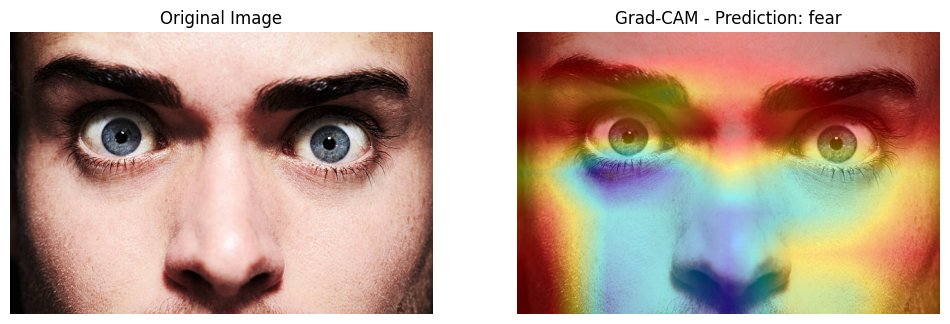

test fear.jpg → Predicted: fear (0.48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


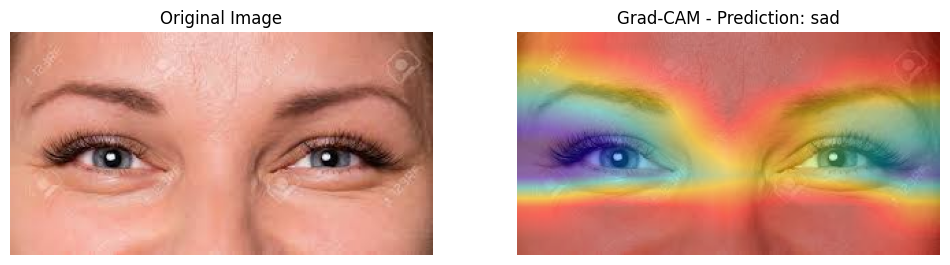

test happy.jpg → Predicted: sad (0.28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


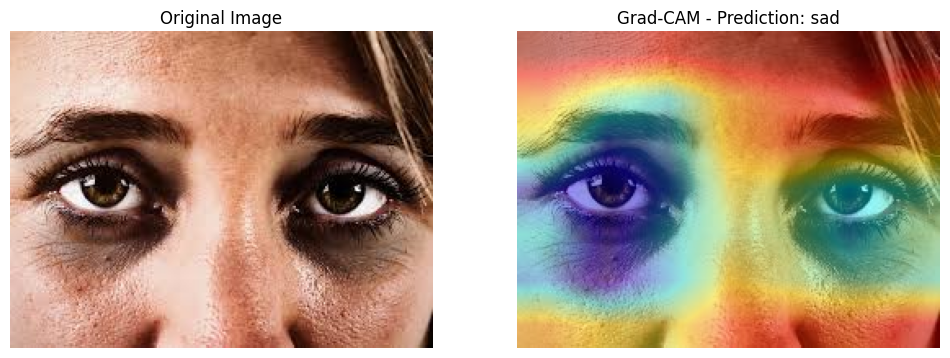

test sad.jpg → Predicted: sad (0.41)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


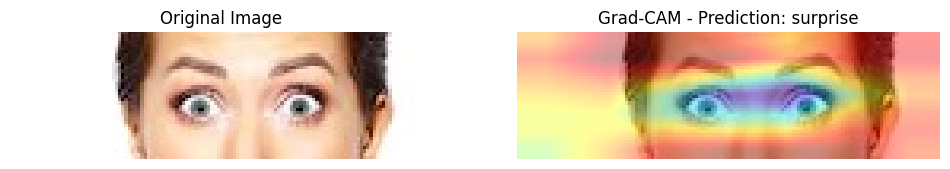

test surprise.jpg → Predicted: surprise (0.30)


In [ ]:
# 11) Grad-CAM for DenseNet121
# Default last conv block name used here is 'conv5_block16_concat'
def generate_gradcam_densenet(model, img_path, last_conv_layer_name='conv5_block16_concat', preprocess_func=densenet_preprocess, img_size=(224,224)):
    # Load and preprocess
    img = load_img(img_path, target_size=img_size)
    img_arr = img_to_array(img)
    img_exp = np.expand_dims(img_arr, axis=0)
    img_pre = preprocess_func(img_exp)

    preds = model.predict(img_pre)
    pred_index = np.argmax(preds[0])

    # Build grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_pre)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - Prediction: {class_labels_list[pred_index]}")
    plt.axis('off')
    plt.show()

    return preds, class_labels_list[pred_index]

# Generate Grad-CAM for uploaded images if any
for img_path in uploaded_paths:
    preds, pred_class = generate_gradcam_densenet(model, img_path, last_conv_layer_name='conv5_block16_concat', preprocess_func=densenet_preprocess, img_size=(224,224))
    print(f"{img_path} → Predicted: {pred_class} ({np.max(preds[0]):.2f})")





In [ ]:
# 12) Save final model and download to local PC
# Save final model (explicit)
model.save("densenet121_finetuned_emotion_model.h5")
print("Saved densenet121_finetuned_emotion_model.h5")

# Download (this will open browser download)
from google.colab import files
files.download("densenet121_finetuned_emotion_model.h5")


Saved densenet121_finetuned_emotion_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>